In [1]:
%load_ext autoreload
%autoreload 2

### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [4]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [5]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    debug = not torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, debug=debug),
        batch_size=100, shuffle=True, num_workers=16,
    )
    dev = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug),
        batch_size=100, shuffle=True, num_workers=16,
    )
    model = LocalizerNet(YOLO_PATH, use_full_yolo=True)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.45e-4,
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 15, 20, 25, 30, 45, 50, 60, 75, 85, 95])
    r = train_localizer(
        model, optimizer, dataset, dev, epochs=50, 
        scheduler=None, restore=False
    )
    return r    

In [6]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

IndexError: too many indices for tensor of dimension 3

In [7]:
def plot(train, dev, title):
    plt.title(title)
    plt.plot(train, label='train'); plt.plot(dev, label='dev')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

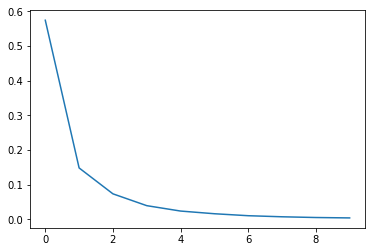

In [17]:
plt.plot(train_losses)

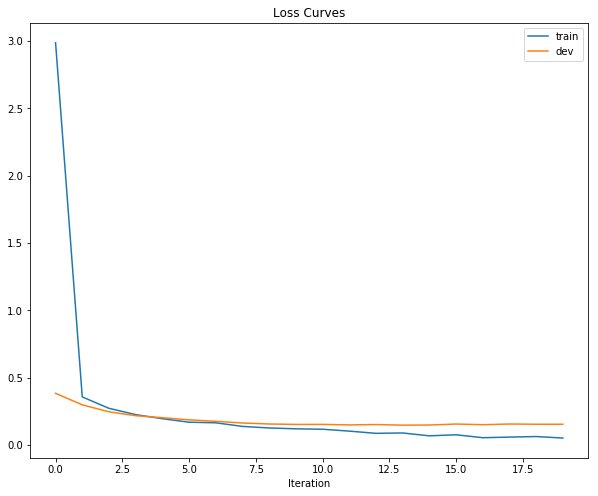

In [17]:
plot(train_losses[0::100], dev_losses, title='Loss Curves')

In [ ]:
# plt.plot(dev_map)
plt.plot(train_map, '-o')
# plt.savefig('goals2.png')

In [ ]:
def calculate_mean_image():
    '''
    calculate the mean image on the training set at 
    different sizes, (270, 480) and (540, 960)
    '''
    IMAGE_DIR = '../Data/FullData/RawImages/'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    image_paths = [os.path.join(IMAGE_DIR, f) for f in np.load(DATA_PATH).item()['train']]
    mean_270, mean_540 = np.zeros((480, 270, 3)), np.zeros((960, 540, 3))
    for img in tqdm(image_paths):
        mean_270 += resized_image((1080//4, 1920//4), img)
        mean_540 += resized_image((1080//2, 1920//2), img)
    N = len(image_paths)
    return mean_270 / N, mean_540 / N

def resized_image(size, path):
    with Image.open(path) as img:
        img = img.resize(size, resample=Image.BILINEAR)
        img = np.asarray(img)
    return img

In [ ]:
# # s, l = calculate_mean_image()
# mean_image_s, mean_image_l = (
#     Image.fromarray(s.astype('uint8'), 'RGB'), 
#     Image.fromarray(l.astype('uint8'), 'RGB')
# )